# Notes on limb darkening normalization

This notebook discusses a major change in how limb darkening is applied to spherical harmonic maps in `starry v1.0.0`. As we will see, we had a serious thinko in the beta version (`<= v0.3.0`) of the code. Note that these changes **do not** affect purely limb-darkened maps (i.e., transits across limb-darkened but otherwise uniform stars).

In [1]:
# Install the beta version
!pip install git+https://github.com/rodluger/starry_beta#egg=starry_beta

In [2]:
import starry_beta as starry
print("Using starry version %s" % starry.__version__)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using starry version 0.3.0


Consider a dipole map with a small DC offset. Let's instantiate it with the original version of `starry` and take a look at the rendered map.

In [3]:
map = starry.Map()
map[0, 0] = 0.01
map[1, 0] = 1
map.animate()

Cool. Now let's add strong linear limb darkening:

In [4]:
map[1] = 1
map.animate()

Looks reasonable. However, things get really weird if we increase the DC offset:

In [5]:
map[0, 0] = 1
map.animate()

What's going on? The image is actually fine most of the time, but at two distinct phases, the specific intensity across the map becomes very, very large. The reason for this is that in the first release of `starry` (`v0.2.2`), the limb darkening normalization was unphysical.

Traditional limb darkening laws tell you how the specific intensity scales with the projected radius on the disk, but only up to an unknown normalization constant. In other words, the laws all tell you what $\frac{I(x, y)}{I_0}$ is, but what we really want to know is $I(x, y)$.

In `starry 0.2.2`, we made the (somewhat reasonable) assumption that limb darkening should not affect the total disk-integrated flux. In other words, limb darkening should only **re-arrange** the intensity on the surface of the visible disk, making the edges darker and the center brighter. But if you integrate over the entire disk you should get the same number -- the total flux coming from the object -- no matter what limb darkening coefficients you use.

And that makes perfect sense for stars with uniform photospheric emission, since it follows from the idea that the star should appear the same from all vantage points. If I were to turn on limb darkening and the flux I measure (say) decreased, it would have to decrease for **all** observers throughout the universe. But that would mean the total luminosity of the star decreased, which is unphysical. (If limb darkening actually did decrease the total luminosity of a star, the star wouldn't be in thermodynamic equilibrium. And since it would be producing more energy than it was radiating, it would have to heat up, until its luminosity returned to the original value.) We therefore assumed that the normalization constant was such that the total flux seen by an observer had to remain unchanged.

Again, that works well for stars, but it actually **fails for bodies whose surfaces are not uniform.** The animation above is the perfect example. But why?

Let's dig in by actually computing fluxes the old-fashioned way: by pixelizing the surface of the body and summing pixels. Below we'll manually compute the rotational light curve of the dipole map above with and without limb darkening. But we won't apply the normalization just yet.

In [6]:
# Generate a map with no limb darkening
# (we will add it in manually)
map = starry.Map()
map[0, 0] = 1
map[1, 0] = 1

# Let's evaluate the specific intensity
# on a grid with this resolution...
res = 75

# ... over this grid of theta values
ntheta = 100
theta = np.linspace(0, 360, ntheta)

# We will compute the total flux...
flux = np.zeros_like(theta)

# ... as well as the total flux for
# a linearly limb-darkened map, **without**
# applying the traditional normalization
flux_ld = np.zeros_like(theta)

# Loop over theta and the xy position on the disk
for i in range(ntheta):
    for x in np.linspace(-1, 1, res):
        for y in np.linspace(-1, 1, res):
            I = map(x=x, y=y, theta=theta[i])
            if not np.isnan(I):
                # Flux
                flux[i] += I
                
                # Limb-darkened flux
                z = np.sqrt(1 - x ** 2 - y** 2)
                flux_ld[i] += I * z
                
flux *= 4 / res ** 2
flux_ld *= 4 / res ** 2

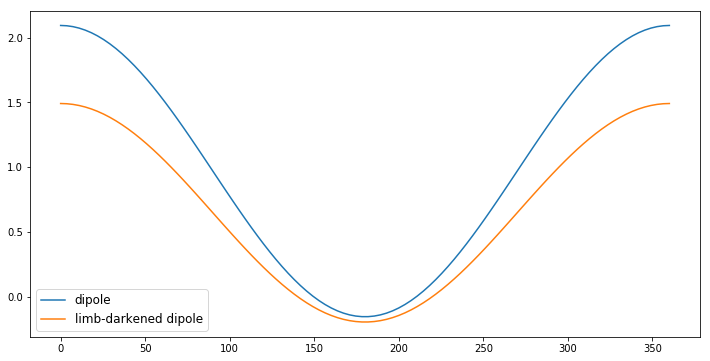

In [7]:
fig = plt.figure(figsize=(12, 6))
plt.plot(theta, flux, label="dipole")
plt.plot(theta, flux_ld, label="limb-darkened dipole")
plt.legend(fontsize=12);

We can clearly see the effect of limb darkening: the disk-integrated flux has dropped everywhere, meaning the actual luminosity of the object decreased. That's not physical, so we **do** need a normalization. What we used to do in `starry` was to multiply the limb-darkened map by the ratio of the two curves in the plot above, as this would (by construction) preserve the disk-integrated flux everywhere.

And this works well most of the time, but notice that the two curves cross `y=0` at *different* phases, so we're bound to get some wacky divisions by very small numbers. Here's the ratio of the two curves:

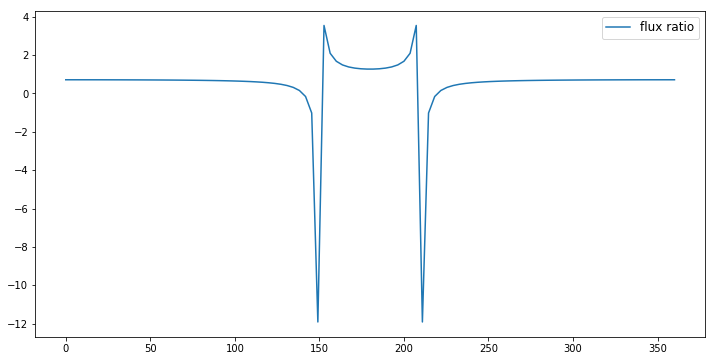

In [8]:
fig = plt.figure(figsize=(12, 6))
ratio = flux_ld / flux
plt.plot(theta, ratio, label="flux ratio")
plt.legend(fontsize=12);

The normalization is roughly constant for most phases, but it diverges near phases of 150 and 210 degrees. Let's look at the maps we get in the vicinity of 150 degrees:

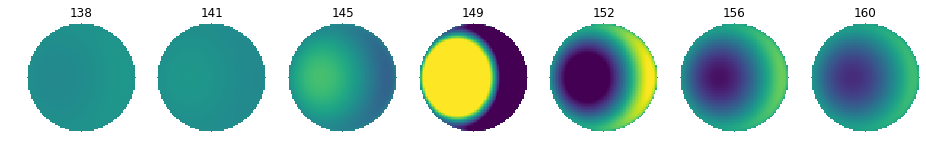

In [9]:
# Loop over theta and the xy position on the disk
fig, ax = plt.subplots(1, 7, figsize=(16, 4))
n = 0
for i in range(38, 45):
    I = np.empty((res, res))
    for k, x in enumerate(np.linspace(-1, 1, res)):
        for j, y in enumerate(np.linspace(-1, 1, res)):
            I[j, k] = map(x=x, y=y, theta=theta[i])
            if not np.isnan(I[j, k]):
                I[j, k] *= np.sqrt(1 - x ** 2 - y** 2)
    ax[n].imshow(I * ratio[i], vmin=-0.5, vmax=0.5)
    ax[n].axis('off')
    ax[n].set_title("%.2d" % theta[i])
    n += 1

As expected, things go crazy near 150 degrees. The normalization in `starry < v1.0.0` is therefore **not** the way to go.

## A better normalization

A better way to normalize is to go back to the very principle that motivated the need for normalization in the first place: conservation of energy (i.e., luminosity). **Limb darkening cannot change an object's luminosity, so that's what we should use to compute the normalization!** We shouldn't assume anything about the *disk-integrated flux* being conserved; that only works for stars whose surfaces are uniform.

But it's tricky to think about computing the total luminosity of an arbitrary limb-darkened object. A brain-dead way to do this is to measure the disk-integrated flux coming from that object from every possible vantage point: that is proportional (or equal to, in the right units) the object's luminosity. If you put an observer everywhere on the surface of a large sphere centered on the object, and ask every observer to count all the photons they see, add those up and you now know how many photons the object emitted in total.

In other words, if we can compute a disk-integrated flux measured from a certain vantage point in $(\theta, \phi)$, all we need to do is integrate that value over all $(\theta, \phi)$. **That** is the value that cannot change, regardless of the limb darkening.

An alternative way to think about this is that the **average** disk-integrated flux cannot change. So if we rotate our map randomly and measure the flux a bunch of times, we want the average of those values to be independent of limb darkening.

OK, but how do we compute this integral, for an arbitrary map? I puzzled over this for a while, since the limb darkening procedure is not a linear operation (at least I haven't figured out how to make it linear yet). That makes it very hard to compute this integral analytically. But after thinking about this for a while, I convinced myself that the normalization **cannot depend on what the map looks like.** In other words, whether my map is the spherical harmonic expansion of the Earth or a simple uniform map, the normalization constant will be the same, and depend **only** on the limb-darkening coefficients.

This is related to the fact that the only spherical harmonic that integrates to something nonzero over $4\pi$ steradians is the $Y_{0,0}$ harmonic. All others contribute net zero luminosity. So, assuming my hypothesis is correct, all we need to do is compute the normalization for a uniform limb-darkened map, and that should apply for **all** maps.

### The total luminosity of a limb-darkened map

From the `starry` paper, the total disk-integrated flux from a map described by the spherical harmonic coefficient vector $\mathbf{y}$ is

$f = \mathbf{r}^T \mathbf{A_1} \mathbf{R} \mathbf{y}$

In the case of a uniform limb-darkened map, $\mathbf{y} = \mathbf{U} \mathbf{u}$ (a linear transform of the limb darkening coefficients $\mathbf{u}$) and $\mathbf{R} = \mathbf{I}$, so

$f = \mathbf{r}^T \mathbf{A_1} \mathbf{U} \mathbf{u}$

Let's define $\mathbf{p_u} = \mathbf{A_1} \mathbf{U} \mathbf{u}$; this is the polynomial corresponding to the limb darkening law. We have

$f = \mathbf{r}^T \mathbf{p_u}$

Since this is the flux measured by all observers, this is also the average flux, so **this is the quantity that is invariant under limb darkening.**

Let's compute this quantity for the two maps above (the dipole and the limb-darkened dipole):

In [10]:
from scipy.special import gamma
def rT(n):
    """Compute the n^th term in the rotation solution vector `r` analytically."""
    l = int(np.floor(np.sqrt(n)))
    m = n - l * l - l
    mu = l - m
    nu = l + m
    if (mu % 2 == 0) and ((mu / 2) % 2 == 0) and (nu % 2 == 0) and ((nu / 2) % 2 == 0):
        return gamma(mu / 4 + 0.5) * gamma(nu / 4 + 0.5) / gamma((mu + nu) / 4 + 2)
    elif ((mu - 1) % 2 == 0) and (((mu - 1) / 2) % 2 == 0) and ((nu - 1) % 2 == 0) and (((nu - 1) / 2) % 2 == 0):
        return 0.5 * np.sqrt(np.pi) * gamma(mu / 4 + 0.25) * gamma(nu / 4 + 0.25) / gamma((mu + nu) / 4 + 2)
    else:
        return 0

For no limb darkening, our polynomial is $\mathbf{p_u} = 1$, which in the `starry` notation corresponds to the polynomial vector $(1\ 0\ 0\ 0)$. We dot that into $\mathbf{r}^T$ and get 

In [11]:
norm1 = rT(0)
norm1

3.1415926535897927

For linear limb darkening, our polynomial is simply $\mathbf{p_u} = z$, which corresponds to the polynomial vector $(0\ 0\ 1\ 0)$. We dot that into $\mathbf{r}^T$ and get

In [12]:
norm2 = rT(2)
norm2

2.094395102393195

Dividing each curve by their respective normalization constants, we get

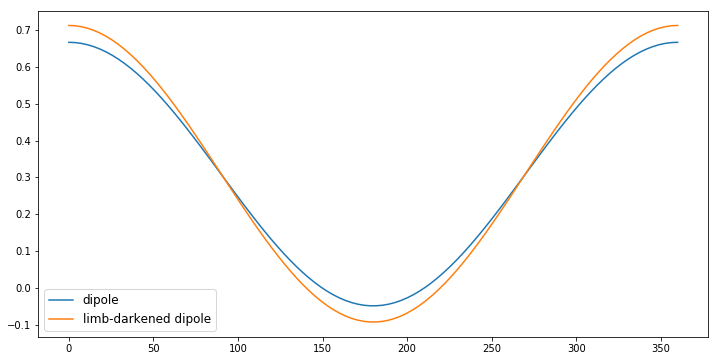

In [13]:
fig = plt.figure(figsize=(12, 6))
plt.plot(theta, flux / norm1, label="dipole")
plt.plot(theta, flux_ld / norm2, label="limb-darkened dipole")
plt.legend(fontsize=12);

**Looks great.** The baselines are now the same, and since the normalization is **constant**, there's no strange behavior at distinct angles.

Note that, in practice, we define the normalization constant to be $\frac{\pi}{\mathbf{r}^T \mathbf{p_u}}$, so that the total flux for a uniform map with no limb darkening is unchanged.